# Joint Line Fit

Create two data sets generated from a linear relation with the same slope but different constant offsets (intercepts).

Perform a chi-square fit to find the common slope and the two intercepts.

Then subclass the `LinFit` class in the [hyperfit](https://hyperfit.readthedocs.io/en/latest/) package to perform the same joint fit using `hyperfit`.

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.optimize import minimize, differential_evolution

from corner import corner

import emcee
from hyperfit.linfit import LinFit

In [2]:
mpl.rc('font', size=14)

## Generate Data

Generate two independent data sets of two different sizes of the form

$$
\begin{align}
y_i^{(1)} &= ax_i^{(1)} + b^{(1)} \\
y_i^{(2)} &= ax_i^{(2)} + b^{(2)}
\end{align}
$$

I.e., the data share a slope but have different constants offsets. The data will also have separate covariances.

In [3]:
n, m = 15, 12

# Common slope but different intercepts.
a, b1, b2 = 2., 1., 2.

# Generate the first data set, and pack the results into the arrays data1 and cov1.
x1 = np.random.rand(n)
y1 = np.random.normal(a*x1 + b1, 0.2)
dx1, dy1, corrxy1 = (
    0.05 * np.random.rand(n) + 0.025,
    0.05 * np.random.rand(n) + 0.025,
    2.0 * (np.random.rand(n) - 0.5)
)
data1, cov1 = np.empty((2, n)), np.empty((2, 2, n))
for i, (x, y, ex, ey, rho_xy) in enumerate(zip(x1, y1, dx1, dy1, corrxy1)):
    cov1[:, :, i] = np.array([[ex ** 2, ex * ey * rho_xy], [ex * ey * rho_xy, ey ** 2]])
    data1[:, i] = np.random.multivariate_normal([x, y], cov1[:, :, i])

# Generate the second data set, and pack the results into the arrays data2 and cov2.
x2 = np.random.rand(m)
y2 = np.random.normal(a*x2 + b2, 0.2)
dx2, dy2, corrxy2 = (
    0.05 * np.random.rand(m) + 0.025,
    0.05 * np.random.rand(m) + 0.025,
    2.0 * (np.random.rand(m) - 0.5)
)
data2, cov2 = np.empty((2, m)), np.empty((2, 2, m))
for i, (x, y, ex, ey, rho_xy) in enumerate(zip(x2, y2, dx2, dy2, corrxy2)):
    cov2[:, :, i] = np.array([[ex ** 2, ex * ey * rho_xy], [ex * ey * rho_xy, ey ** 2]])
    data2[:, i] = np.random.multivariate_normal([x, y], cov2[:, :, i])

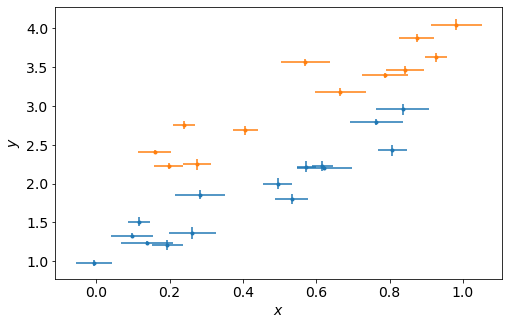

In [4]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
eb1 = ax.errorbar(data1[0], data1[1], xerr=np.sqrt(cov1[0,0]), yerr=np.sqrt(cov1[1,1]), fmt='.')
eb2 = ax.errorbar(data2[0], data2[1], xerr=np.sqrt(cov2[0,0]), yerr=np.sqrt(cov2[1,1]), fmt='.')
ax.set(xlabel='$x$', ylabel='$y$');

## Standard Fit

Attempt a standard $\chi^2$ fit to the data. Use both the uncertainties in $x$ and $y$, but ignore the covariances. Here we use the form of the $\chi^2$ defined in **Numerical Recipes in C++**, eq. 15.3.2:

$$
\chi^2(a,b) = \sum_{i}\frac{(y_i-ax_i-b)^2}{\sigma_{y_i}^2 + a^2\sigma_{x_i}^2}
$$

In this case, we divide the data in two and specify the parameters as the array `[a, b1, b2]`.

In [5]:
def chi2(params, data1, data2, cov1, cov2):
    """Chi-square function for joint slope fit to two data sets.
    
    Parameters
    ----------
    data1 : ndarray
        2xN array of [x1, y1] for data set 1.
    data2 : ndarray
        2xM array of [x2, y2] for data set 2.
    cov1 : ndarray
        2x2xN covariances for data set 1.
    cov2 : ndarray
        2x2xM covariances for data set 2.
        
    Returns
    -------
    chi2 : float
        Sum of chi-square fits to data sets 1 and 2.
    """
    a, b1, b2 = params
    
    x1, y1 = data1[0], data1[1]
    varx1, vary1 = cov1[0,0], cov1[1,1]
    chi2_1 = np.sum((y1 - a*x1 - b1)**2 / (vary1 + a**2*varx1))
    
    x2, y2 = data2[0], data2[1]
    varx2, vary2 = cov2[0,0], cov2[1,1]
    chi2_2 = np.sum((y2 - a*x2 - b2)**2 / (vary2 + a**2*varx2))
    
    return chi2_1 + chi2_2

### Peform the Fit and Plot Results

Use the `BFGS` minimizer to find the best fit parameters.

Note that the result may depend sensitively on the initial seed values.

In [6]:
p0 = [1.5, 0.7, 1.2]
res = minimize(chi2, p0, args=(data1, data2, cov1, cov2), method='BFGS')
res

      fun: 84.46680471373298
 hess_inv: array([[ 0.00274635, -0.00110964, -0.00143281],
       [-0.00110964,  0.00089611,  0.00059266],
       [-0.00143281,  0.00059266,  0.00120683]])
      jac: array([-9.53674316e-07, -9.53674316e-06, -3.81469727e-06])
  message: 'Optimization terminated successfully.'
     nfev: 56
      nit: 12
     njev: 14
   status: 0
  success: True
        x: array([2.00554929, 1.0229232 , 1.96199002])

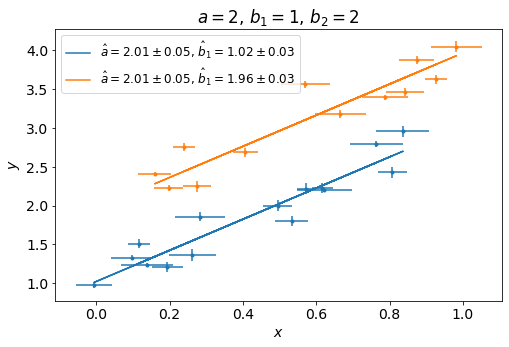

In [7]:
a_, b1_, b2_ = res.x
da_, db1_, db2_ = [np.sqrt(res.hess_inv[i,i]) for i in range(3)]

fig, ax = plt.subplots(1,1, figsize=(8,5))
eb1 = ax.errorbar(data1[0], data1[1], xerr=np.sqrt(cov1[0,0]), yerr=np.sqrt(cov1[1,1]), fmt='.')
ax.plot(data1[0], a_*data1[0] + b1_, color=eb1[0].get_color(),
        label=r'$\hat{{a}}={:.2f}\pm{:.2f}$, $\hat{{b}}_1={:.2f}\pm{:.2f}$'.format(a_, da_, b1_, db1_))

eb2 = ax.errorbar(data2[0], data2[1], xerr=np.sqrt(cov2[0,0]), yerr=np.sqrt(cov2[1,1]), fmt='.')
ax.plot(data2[0], a_*data2[0] + b2_, color=eb2[0].get_color(),
        label=r'$\hat{{a}}={:.2f}\pm{:.2f}$, $\hat{{b}}_1={:.2f}\pm{:.2f}$'.format(a_, da_, b2_, db2_))

ax.set(xlabel='$x$', ylabel='$y$',
       title='$a={:g}$, $b_1={:g}$, $b_2={:g}$'.format(a, b1, b2))
ax.legend(fontsize=12);

## Enable a Joint Fit in `hyperfit`

Here we set up a new class that can handle multiple data sets at once. The main condition is that the linear fits to the data always have a common slope.

In [8]:
def nlogl(params, datasets, covs):
    """Chi-square function for joint slope fit to two or more data sets.
    
    Parameters
    ----------
    datasets : list or ndarray
        m x 2xN array of [x1, y1] for each data set.
    cov : ndarray
        m x 2x2xN covariances for each data set.
        
    Returns
    -------
    chi2 : float
        Sum of chi-square fits to data sets 1 and 2.
    """
    nsets = len(datasets)
    a = params[0]
    b = params[1:nsets+1]
    sigma = params[nsets+1:]
    
    nloglike = 0.
    for i in range(nsets): 
        data = datasets[i]
        cov = covs[i]
        x, dx2 = data[0], cov[0,0]
        y, dy2 = data[1], cov[1,1]
        dxy = cov[0,1]
        sy2 = sigma[i]**2 + a**2*dx2 + dy2 - 2*dxy*a
        nloglike += -0.5*np.sum(np.log((a**2 + 1)/sy2) - (a*x - y + b[i])**2/sy2)
    
    return nloglike

# Minimization.
print('Differential evolution:')
bounds = [[-10., 10.], [-6., 6.], [-5., 5.], [0, 1], [0, 2]]
res = differential_evolution(nlogl, bounds, args=([data1, data2], [cov1, cov2]))
print(res)

# Initial guesses
slope = 1.5
intercepts = [0.7, 1.3]
sigmas = [0.2, 0.3]
p0 = [slope] + intercepts + sigmas

print('\n\nBFGS minimization:')
res = minimize(nlogl, p0, args=([data1, data2], [cov1, cov2]), method='BFGS')
print(res)

Differential evolution:
     fun: -52.610165239804644
     jac: array([ 1.26476608e-04, -2.39452901e-04,  3.02691207e-04,  7.24753591e-05,
       -1.27897693e-05])
 message: 'Optimization terminated successfully.'
    nfev: 2766
     nit: 35
 success: True
       x: array([2.11668509, 0.97667703, 1.89983962, 0.15009353, 0.2027716 ])


BFGS minimization:
      fun: -52.61016524010543
 hess_inv: array([[ 0.02257163, -0.0098039 , -0.01306997,  0.00238122,  0.00142644],
       [-0.0098039 ,  0.00689398,  0.00568874, -0.00087755, -0.00059087],
       [-0.01306997,  0.00568874,  0.01161541, -0.00132967, -0.00074231],
       [ 0.00238122, -0.00087755, -0.00132967,  0.00195986,  0.00014942],
       [ 0.00142644, -0.00059087, -0.00074231,  0.00014942,  0.00263091]])
      jac: array([-9.53674316e-07, -9.53674316e-07,  0.00000000e+00, -9.53674316e-07,
        1.43051147e-06])
  message: 'Optimization terminated successfully.'
     nfev: 264
      nit: 26
     njev: 44
   status: 0
  success: Tru

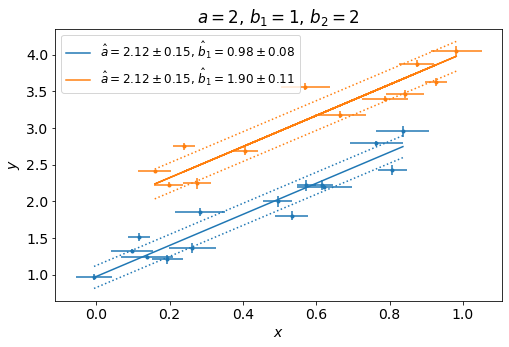

In [9]:
a_, b1_, b2_, sig1_, sig2_ = res.x
da_, db1_, db2_ = [np.sqrt(res.hess_inv[i,i]) for i in range(3)]

fig, ax = plt.subplots(1,1, figsize=(8,5))
eb1 = ax.errorbar(data1[0], data1[1], xerr=np.sqrt(cov1[0,0]), yerr=np.sqrt(cov1[1,1]), fmt='.')
x_ = np.linspace(np.min(data1[0]), np.max(data1[0]))
ax.plot(x_, a_*x_ + b1_, color=eb1[0].get_color(),
        label=r'$\hat{{a}}={:.2f}\pm{:.2f}$, $\hat{{b}}_1={:.2f}\pm{:.2f}$'.format(a_, da_, b1_, db1_))
ax.plot(x_, a_*x_ + b1_ + sig1_, ls=':', color=eb1[0].get_color())
ax.plot(x_, a_*x_ + b1_ - sig1_, ls=':', color=eb1[0].get_color())

eb2 = ax.errorbar(data2[0], data2[1], xerr=np.sqrt(cov2[0,0]), yerr=np.sqrt(cov2[1,1]), fmt='.')

x_ = np.linspace(np.min(data2[0]), np.max(data2[0]))
ax.plot(data2[0], a_*data2[0] + b2_, color=eb2[0].get_color(),
        label=r'$\hat{{a}}={:.2f}\pm{:.2f}$, $\hat{{b}}_1={:.2f}\pm{:.2f}$'.format(a_, da_, b2_, db2_))
ax.plot(x_, a_*x_ + b2_ + sig2_, ls=':', color=eb2[0].get_color())
ax.plot(x_, a_*x_ + b2_ - sig2_, ls=':', color=eb2[0].get_color())

ax.set(xlabel='$x$', ylabel='$y$',
       title='$a={:g}$, $b_1={:g}$, $b_2={:g}$'.format(a, b1, b2))
ax.legend(fontsize=12);

## Encapsulate Multi-Dataset Fits in a Single Class

Define a class `MultiLinFit` that takes in a list of datasets and covariances, each in the same format used by `LinFit` in the hyperfit package. I.e.,
* `data` are 2xN arrays, and `datasets` is a list of `data`.
* `cov` are 2x2xN arrays, and `covs` is a list of `cov`.

Note that the data sets can be different sizes.

While the `LinFit` class allows for higher-dimensional fits -- planes and hyperplanes in addition to lines -- this class only fits lines, as needed for the Tully-Fisher relation. It is assumed that all data sets share a common slope but have different intercepts and scatter parameters. The fit parameters are of the form

$$
\vec{\theta} = (a, b_1, b_2, \ldots, b_m, \sigma_1, \sigma_2, \ldots, \sigma_m),
$$

where $a$ is the common slope, $b_1,\ldots,b_m$ are the intercepts for the $m$ datasets, and $\sigma_1,\ldots,\sigma_m$ are the scatter parameters for each dataset.

In [10]:
class MultiLinFit:
    
    def __init__(self, datasets, covs, weights=None, vertaxis=-1):
        
        self.nsets = len(datasets)
        self.ndims = np.shape(datasets[0])[0]
        self.ndata = [np.shape(data)[1] for data in datasets]
        self.datasets = datasets
        self.covs = covs
        self.data = None
        self.cov = None
        
        self.npars = 1 + self.nsets # slope + intercepts + sigmas
        self.params = np.zeros(self.npars)
        self.params_scatter = np.zeros(self.nsets)
        
        self.weights = [np.ones(n) for n in self.ndata] if weights is None else weights
        self.vertaxis = vertaxis
        
        self.param_bounds = None      # parameter fit bounds for all data sets
        
    def _lnpost(self, params):
        lnpost = 0.

        for i in range(self.nsets):
            # Loop over individual data sets. 
            self.data = self.datasets[i]
            self.cov  = self.covs[i]
            
            # Set up parameter and bounds arrays for each data set.
            pars_i = np.array([params[0]] + [params[1+i]] + [params[self.nsets+1+i]])
            bounds_i = [self.param_bounds[0]] + \
                       [self.param_bounds[1+i]] + \
                       [self.param_bounds[self.nsets+1+i]]

            # Set up weights for each data set.
            weights = self.weights[i]
            
            # Sum over all data sets.
            lnprior = self._lnprior(pars_i, bounds_i)
            lnlike = self._lnlike(pars_i)                
            lnpost += np.sum(weights * lnlike) + lnprior
        
        return lnpost
                    
    def _lnprior(self, params, bounds):
        lnprior = 0.
        for i, (param, bound) in enumerate(zip(params.T, bounds)):
            lnprior += np.where(np.logical_or(param < bound[0], param > bound[1]), -np.inf, 0.0)

        return lnprior
    
    def _lnlike(self, params):
        a, b, sigma = params

        x, dx2 = self.data[0], self.cov[0,0]
        y, dy2 = self.data[1], self.cov[1,1]
        dxy = self.cov[0,1]
        sy2 = sigma**2 + a**2*dx2 + dy2 - 2*dxy*a
        lnlike = 0.5*np.sum(np.log((a**2 + 1)/sy2) - (a*x - y + b)**2/sy2)

        return lnlike
    
    def optimize(self, bounds, tol=1e-6, verbose=False):
        self.param_bounds = bounds
        res = differential_evolution(lambda *args: -self._lnpost(*args), self.param_bounds, tol=tol)

        if verbose:
            print(res)
            
        self.params = res.x[:-self.nsets]
        self.params_scatter = np.fabs(res.x[-self.nsets:])
        return self.params, self.params_scatter, res.fun
    
    def emcee(self, bounds, max_iter=100000, batchsize=1000, ntau=50.0, tautol=0.05, verbose=False):

        # Set up emcee. Start the walkers in a small 1 percent ball around the best fit.
        # The best fit will set self.params and self.params_scatter.
        self.optimize(bounds, verbose=verbose)
        ndim = len(self.params) + len(self.params_scatter)
        nwalker = 4 * ndim
        seeds = np.asarray([
            [(0.01 * np.random.rand() + 0.995) * j for j in np.concatenate([self.params, self.params_scatter])]
            for _ in range(nwalker)
        ])

        sampler = emcee.EnsembleSampler(nwalker, ndim, self._lnpost)

        old_tau = np.inf
        niter = 0
        converged = 0
        while ~converged:
            sampler.run_mcmc(seeds, nsteps=batchsize, progress=verbose)
            tau = sampler.get_autocorr_time(discard=int(0.5 * niter), tol=0)
            converged = np.all(ntau * tau < niter)
            converged &= np.all(np.abs(old_tau - tau) / tau < tautol)
            old_tau = tau
            begin = None
            niter += 1000
            if verbose:
                print("Niterations/Max Iterations: ", niter, "/", max_iter)
                print("Integrated ACT/Min Convergence Iterations: ", tau, "/", np.amax(ntau * tau))
            if niter >= max_iter:
                break

        # Remove burn-in and and save the samples
        tau = sampler.get_autocorr_time(discard=int(0.5 * niter), tol=0)
        burnin = int(2 * np.max(tau))
        samples = sampler.get_chain(discard=burnin, flat=True).T
        mcmc_samples = samples
        mcmc_lnlike = sampler.get_log_prob(discard=burnin, flat=True)

        return mcmc_samples, mcmc_lnlike

In [11]:
mlf = MultiLinFit([data1, data2], [cov1, cov2])

In [12]:
bounds = [[-10., 10.], [-10., 10.], [-10., 10.], [0., 2.], [0., 2.]]
mlf.optimize(bounds, verbose=True)

     fun: -722.304811810932
     jac: array([ 0.01871285,  0.00782165, -0.00561613,  0.00444516, -0.00176215])
 message: 'Optimization terminated successfully.'
    nfev: 5736
     nit: 75
 success: True
       x: array([2.11428446, 0.97770831, 1.90122697, 0.14984443, 0.20260773])


(array([2.11428446, 0.97770831, 1.90122697]),
 array([0.14984443, 0.20260773]),
 -722.304811810932)

In [13]:
# Run an MCMC
bounds = [[-10., 10.], [-10., 10.], [-10., 10.], [0., 2.], [0., 2.]]
mcmc_samples, mcmc_lnlike = mlf.emcee(bounds, max_iter=10000, verbose=True)
print(np.mean(mcmc_samples, axis=1), np.std(mcmc_samples, axis=1))

     fun: -722.3048113027451
     jac: array([ 0.00942464,  0.08076313, -0.03319656,  0.00028422, -0.01921308])
 message: 'Optimization terminated successfully.'
    nfev: 6354
     nit: 83
 success: True
       x: array([2.11424248, 0.97773835, 1.90124185, 0.14984   , 0.20260125])


100%|████████████████████████████████| 1000/1000 [00:03<00:00, 325.30it/s]


Niterations/Max Iterations:  1000 / 10000
Integrated ACT/Min Convergence Iterations:  [37.48835969 37.3469803  37.28271029 37.98148276 41.3266436 ] / 2066.332180028132


100%|████████████████████████████████| 1000/1000 [00:03<00:00, 308.04it/s]


Niterations/Max Iterations:  2000 / 10000
Integrated ACT/Min Convergence Iterations:  [42.37727177 49.57402455 40.65849076 45.90191923 46.05280519] / 2478.701227681972


100%|████████████████████████████████| 1000/1000 [00:02<00:00, 352.24it/s]


Niterations/Max Iterations:  3000 / 10000
Integrated ACT/Min Convergence Iterations:  [42.72420665 42.67870239 42.68080328 53.04832366 54.04785143] / 2702.3925715986793


100%|████████████████████████████████| 1000/1000 [00:02<00:00, 337.18it/s]


Niterations/Max Iterations:  4000 / 10000
Integrated ACT/Min Convergence Iterations:  [42.14361523 43.99392327 43.72560839 55.82884274 60.32145719] / 3016.0728595389405


100%|████████████████████████████████| 1000/1000 [00:03<00:00, 322.83it/s]


Niterations/Max Iterations:  5000 / 10000
Integrated ACT/Min Convergence Iterations:  [42.17583218 43.79004411 40.81371782 51.02901976 57.13046169] / 2856.5230846613304


100%|████████████████████████████████| 1000/1000 [00:02<00:00, 337.67it/s]


Niterations/Max Iterations:  6000 / 10000
Integrated ACT/Min Convergence Iterations:  [39.98871293 42.90949265 37.76979328 48.00563462 57.18645581] / 2859.3227907301775


100%|████████████████████████████████| 1000/1000 [00:02<00:00, 339.80it/s]


Niterations/Max Iterations:  7000 / 10000
Integrated ACT/Min Convergence Iterations:  [43.9575152  46.93689916 44.99943279 54.37491653 56.09854473] / 2804.9272365229017


100%|████████████████████████████████| 1000/1000 [00:02<00:00, 349.14it/s]


Niterations/Max Iterations:  8000 / 10000
Integrated ACT/Min Convergence Iterations:  [46.05642034 46.49634186 44.86550647 54.72150767 55.46411128] / 2773.205564017198
[2.11885998 0.9753333  1.89937869 0.15200815 0.20632184] [0.04029492 0.02164092 0.03014376 0.01150852 0.01493424]


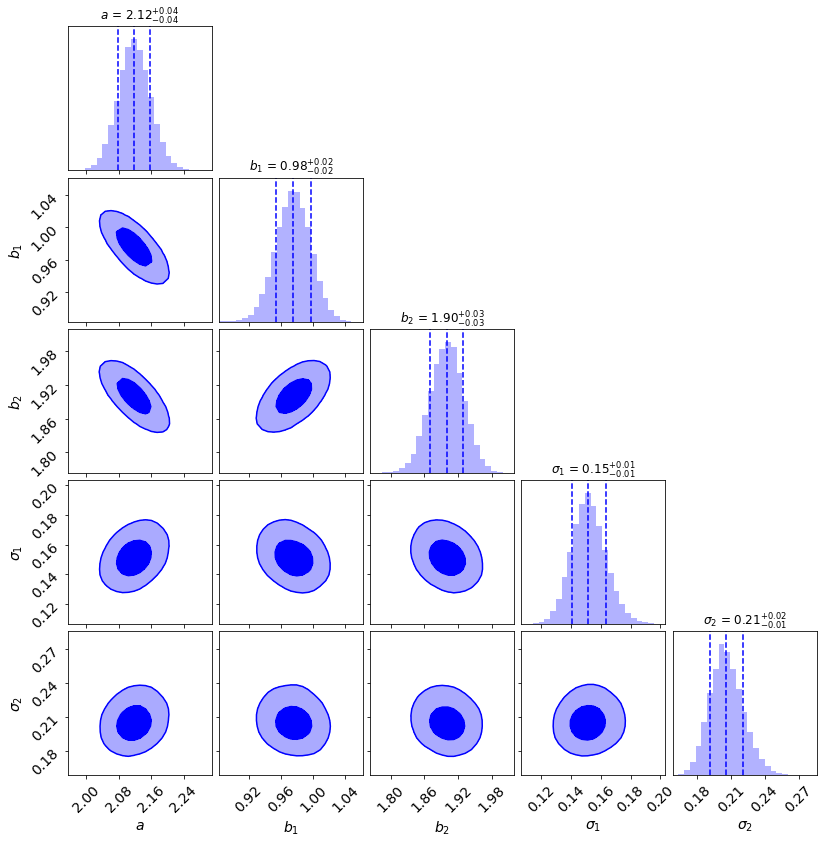

In [14]:
fig = corner(mcmc_samples.T, bins=25, smooth=1,
#              range=[[1.9, 2.4], [0.75, 1.1], [0.1, 0.3]],   # Range for a, b, sigma. Adjust as needed.
             labels=['$a$', '$b_1$', '$b_2$', r'$\sigma_1$', r'$\sigma_2$'],
             levels=(1-np.exp(-0.5), 1-np.exp(-2)),
             quantiles=[0.16, 0.5, 0.84],
             color='blue',
             hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
             plot_datapoints=False,
             fill_contours=True,
             show_titles=True,
             title_kwargs={"fontsize": 12})